In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import DatasetFolder

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc
from sklearn.preprocessing import label_binarize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# !unzip '/content/drive/MyDrive/Colab Notebooks/Warm-ups/dataset.zip' -d '/content/drive/MyDrive/Colab Notebooks/Warm-ups'

In [2]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.to(torch.float32).repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

root = '../dataset'

# Initialize DatasetFolder for train and validation datasets
train_dataset = DatasetFolder(
    root=os.path.join(root, 'train'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)
test_dataset = DatasetFolder(
    root=os.path.join(root, 'val'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)

In [3]:
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.9), int(len(train_dataset) * 0.1)])

In [4]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Classes: {train_dataset.dataset.classes}')
print(f'Image tensor type: {train_dataset[0][0].dtype}')
print(f'Batches: {len(train_loader)}')

Train dataset size: 27000
Val dataset size: 3000
Test dataset size: 7500
Image shape: torch.Size([3, 224, 224])
Classes: ['no', 'sphere', 'vort']
Image tensor type: torch.float32
Batches: 422


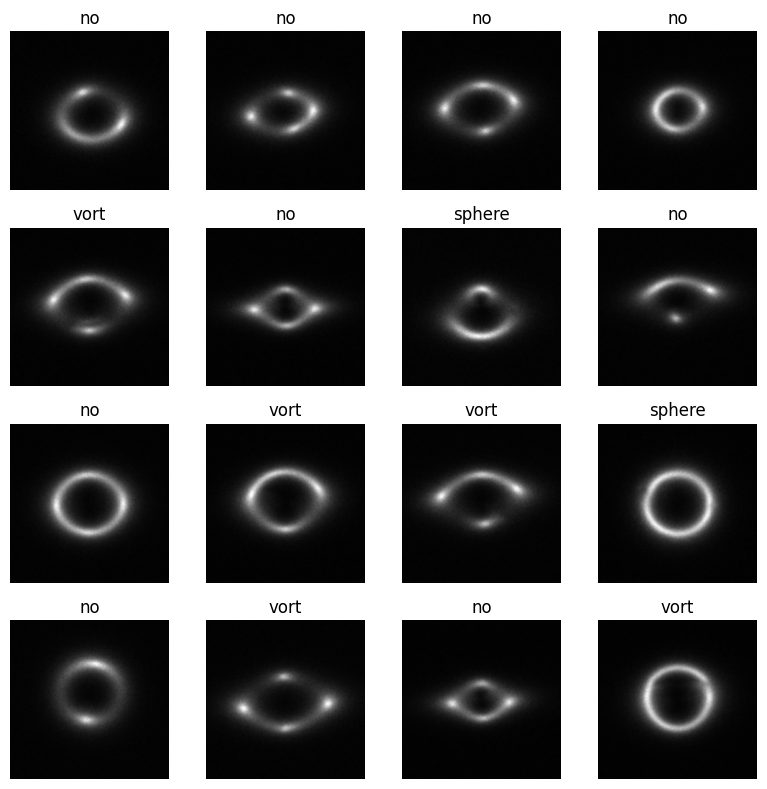

In [6]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# Visualize some images in the train dataset
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    if i < 16:
        image, label = images[i], labels[i]

        img = image.numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(train_dataset.dataset.classes[label])
        ax.axis('off')
    else:
        break

plt.tight_layout()
plt.show()

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            logits = outputs.logits

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(logits, 1)
            train_corrects += torch.sum(preds == labels.data).item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                logits = outputs.logits

                loss = criterion(logits, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(logits, 1)
                val_corrects += torch.sum(preds == labels.data).item()

            val_loss /= len(val_loader.dataset)
            val_acc = val_corrects / len(val_loader.dataset)

        # Step the scheduler
        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_param_ViT.pt')

        print(f'Epoch [{epoch + 1}/{num_epochs}]:')
        print(f'\tTrain Loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}')
        print(f'\tVal Loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}')

    model.load_state_dict(torch.load('best_param_ViT.pt'))

    return model

In [35]:
def evaluate_model(model, criterion):
    model.eval()
    y_pred_probs = []
    y_true = []
    total_loss = 0.0
    total_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            logits = outputs.logits
            loss = criterion(logits, labels)

            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(logits, 1)
            total_corrects += torch.sum(preds == labels).item()

            y_pred_probs.extend(F.softmax(logits, dim=1).cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    test_loss = total_loss / len(test_loader.dataset)
    test_acc = total_corrects / len(test_loader.dataset)

    # Binarize the labels for ROC AUC
    y_true_binary = label_binarize(y_true, classes=[0, 1, 2])

    # Compute ROC AUC
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs, multi_class='ovr')

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {test_acc:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'Outputs: {outputs}')
    print(f'Probabilities: {F.softmax(logits, dim=1)}, {logits.shape}')
    classes = ['no', 'sphere', 'vort']
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, np.argmax(y_pred_probs, axis=1))
    sns.heatmap(cm, annot=True, fmt='d', cmap='icefire', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Plot ROC curve for each class
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(np.array(y_true_binary).ravel(), np.array(y_pred_probs).ravel())
    plt.plot(fpr, tpr, color='red', label=f'ViT, {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

In [54]:
from transformers import ViTForImageClassification, ViTConfig

configuration = ViTConfig()
model_ViT = ViTForImageClassification(configuration).from_pretrained('google/vit-base-patch16-224')
# model_ViT.config.num_labels = 3
model_ViT.config.id2label = {'0': 'no', '1': 'sphere', '2': 'vort'}
model_ViT.config.label2id = {'no': 0, 'sphere': 1, 'vort': 2}
model_ViT.classifier = nn.Linear(in_features=768, out_features=3, bias=True)
model_ViT.to(device)

optimizer = optim.Adam(model_ViT.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
criterion = nn.CrossEntropyLoss()

configuration = model_ViT.config
print(configuration)
model_ViT

ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "no",
    "1": "sphere",
    "2": "vort"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "no": 0,
    "sphere": 1,
    "vort": 2
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.31.0"
}



ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [20]:
for image, label in train_loader:
    print("Pixel values:", image.shape)
    break

Pixel values: torch.Size([64, 3, 224, 224])


In [44]:
model_ViT = train_model(model_ViT, criterion, optimizer, scheduler, num_epochs=10)

Epoch 1/10:
	Train Loss: 1.1144	Train Acc: 0.3304
	Val Loss: 1.0990	Val Acc: 0.3363


KeyboardInterrupt: 

In [45]:
torch.save(model_ViT.state_dict(), 'best_param_ViT.pt')

In [52]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Warm-ups/best_param_ViT.pt'))
model_ViT.load_state_dict(torch.load('best_param_ViT.pt'))

<All keys matched successfully>

Test Loss: 1.1375
Accuracy: 0.3348
ROC AUC: 0.4889
Outputs: ImageClassifierOutput(loss=None, logits=tensor([[-0.1443,  0.2085,  0.0211],
        [-0.1977,  0.4110, -0.1282],
        [-0.1010,  0.3338,  0.1217],
        [-0.3660,  0.3431, -0.1003],
        [-0.2222,  0.4584, -0.2438],
        [-0.1276,  0.7305, -0.1978],
        [-0.3553,  0.3932, -0.2859],
        [-0.2615,  0.5319, -0.2541],
        [-0.2287,  0.2046,  0.1111],
        [-0.1188,  0.4585, -0.2076],
        [-0.2379,  0.2985, -0.1306],
        [-0.2693,  0.0663, -0.0021]], device='cuda:0'), hidden_states=None, attentions=None)
Logits: tensor([[0.2776, 0.3950, 0.3275],
        [0.2558, 0.4701, 0.2742],
        [0.2636, 0.4071, 0.3293],
        [0.2306, 0.4686, 0.3008],
        [0.2529, 0.4996, 0.2475],
        [0.2331, 0.5497, 0.2172],
        [0.2389, 0.5050, 0.2561],
        [0.2371, 0.5241, 0.2388],
        [0.2534, 0.3908, 0.3559],
        [0.2705, 0.4819, 0.2476],
        [0.2616, 0.4472, 0.2912],
        [0.2699, 0

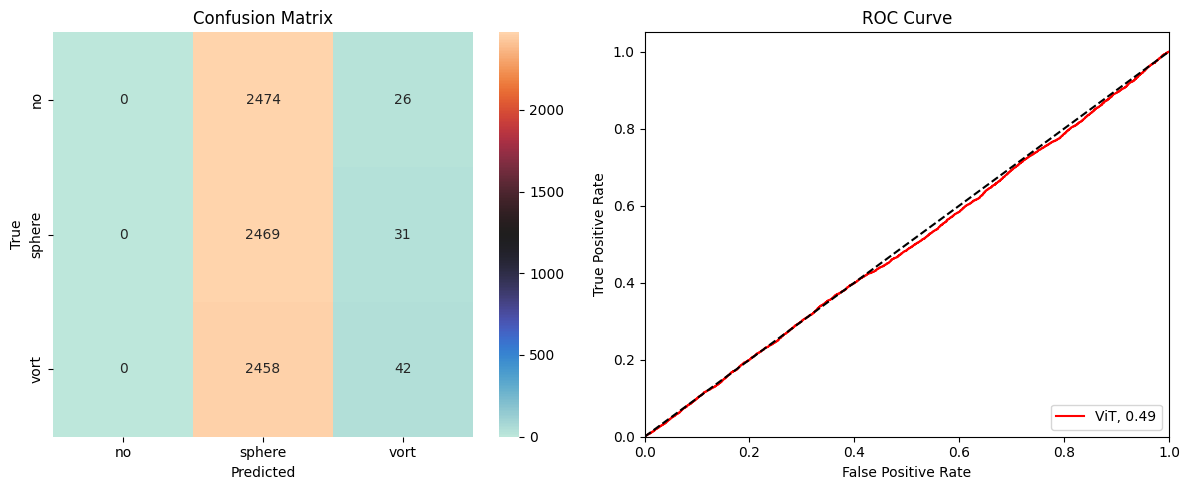

In [53]:
evaluate_model(model_ViT, criterion)